# Traffic Simulation Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# code is adapted from CS166, session 9
class Road:
    """
    A class to represent a single road in a traffic simulation.

    Attributes
    ----------
    road_id : int
        The ID of the road.
    road_length : int, optional
        The length of the road (default is 50).
    car_density : float, optional
        The car density of the road (default is 0.2).
    prob_slow : float, optional
        The probability of a car randomly slowing down (default is 0.2).
    max_speed : int, optional
        The maximum speed of a car (default is 5).
    turn_prob : float, optional
        The probability of a car turning right (default is 0.2).
    incoming_road : Road
        The incoming road to the intersection.
    incoming_position : int
        The position of the intersection on the incoming road.
    outgoing_road : Road
        The outgoing road from the intersection.
    outgoing_position : int
        The position of the intersection on the outgoing road.
    state : numpy.ndarray
        The state of the road, including all speeds of cars and their positions.
    time_step : int
        The current time step.
    average_traffic_flow : list
        A list of average traffic flows for each time step.
    traffic_light_queue_incoming : list
        A list of traffic queue lengths at the incoming intersection for each time step.
    traffic_light_queue_outgoing : list
        A list of traffic queue lengths at the outgoing intersection for each time step.

    Methods
    -------
    define_incoming_road(incoming_road, incoming_position)
        Sets the incoming road and position.
    define_outgoing_road(outgoing_road, outgoing_position)
        Sets the outgoing road and position.
    calculate_queue_length(start_position)
        Calculates the queue length at a given position.
    right_turn()
        Handles cars turning right at the intersection.
    update(traffic_light_state)
        Updates the state of the road.
    """

    def __init__(self, road_id, road_length=50, car_density=0.2, prob_slow=0.2,
                 max_speed=5, turn_prob=0.2):
        """
        Parameters
        ----------
        road_id : int
            The ID of the road.
        road_length : int, optional
            The length of the road (default is 50).
        car_density : float, optional
            The initial car density of the road (default is 0.2).
        prob_slow : float, optional
            The probability of a car randomly slowing down (default is 0.2).
        max_speed : int, optional
            The maximum speed of a car (default is 5).
        turn_prob : float, optional
            The probability of a car turning right (default is 0.2).
        """
        self.road_id = road_id
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        self.turn_prob = turn_prob

        # create empty road (-1 is empty)
        self.state = np.full(self.road_length, -1, dtype=int)

        # place cars at random indexes
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        
        # each car has random initial speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))
        
        self.time_step = 0
        self.average_traffic_flow = []
        self.traffic_light_queue_incoming = []
        self.traffic_light_queue_outgoing = []

    def define_incoming_road(self, incoming_road, incoming_position):
        """
        Define the incoming road and position for the intersection.

        Parameters
        ----------
        incoming_road : Road obj
            The incoming road (an object of this class).
        incoming_position : int
            The position of the intersection for the incoming road.
        """
        self.incoming_road = incoming_road
        self.incoming_position = incoming_position

    def define_outgoing_road(self, outgoing_road, outgoing_position):
        """
        Define the outgoing road and position for the intersection.

        Parameters
        ----------
        outgoing_road : Road obj
            The outgoing road (an object of this class).
        outgoing_position : int
            The position of the intersection for the outgoing road.
        """
        self.outgoing_road = outgoing_road
        self.outgoing_position = outgoing_position

    def calculate_queue_length(self, start_position):
        """
        Calculate the length of the queue of stationary cars back from a given position.

        Parameters
        ----------
        start_position : int
            The starting position to check for stationary cars.

        Returns
        -------
        queue_length : int
            The length of the queue of stationary cars backwards from the starting position.
        """
        queue_length = 0
        i = start_position

        # move backwards from position and check for stationary cars
        while self.state[i] == 0:
            queue_length += 1
            i -= 1

            # check that i doesn't go beyond road length
            if i < 0:
                i = self.road_length - 1

        return queue_length

    def right_turn(self):
        """
        Moves cars that are able to turn right onto the outgoing road with a probability based on the attribute self.turn_prob.
        """
        # check for cars that are able to move onto outgoing road
        for i in range(self.outgoing_position+self.max_speed, self.outgoing_position-1, -1):
            
            # periodicity (if intersection is close to end of road)
            car_idx = i % self.road_length

            # if there is a car
            if self.state[car_idx] != -1:

                # the car turns right
                if random.random() < self.turn_prob:

                    new_road = self.outgoing_road

                    # distance past the intersection
                    distance_past_intersection = i-self.outgoing_position

                    # distance moved to the intersection
                    distance_to_intersection = self.state[car_idx] - distance_past_intersection

                    # distance that the car can move along new road
                    distance_next_road = 1
                    while new_road.state[(new_road.incoming_position + distance_next_road) % new_road.road_length] == -1 and distance_next_road <= new_road.max_speed:
                        distance_next_road += 1

                    # change car speed based on next car along new road
                    new_car_speed = min(distance_to_intersection + distance_next_road - 1, self.state[car_idx])

                    # move car onto outgoing road
                    new_road.state[self.incoming_position+distance_past_intersection+1] = new_car_speed
                    self.state[car_idx] = -1

    def update(self, traffic_light_state):
        """
        Update the state of the road based on the given traffic light state. At state 0, the
        first traffic light on the road is red, and the second is green. At state 1, the first 
        traffic light on the road is green, and the second is red. At state 0, cars are able to turn 
        right onto the outgoing road at the second traffic light. Otherwise, cars are
        subject to acceleration, deceleration and randomisation as per Nagel-Schreckenberg (1992).

        Parameters
        ----------
        traffic_light_state : int
            The state of the traffic light (0 or 1).
        """
        if traffic_light_state == 0:
            # place a stationary car at incoming_position (traffic light) to prevent cars moving
            self.state[self.incoming_position] = 0
        else:
            # place a stationary car at outgoing_position (traffic light) to prevent cars moving
            self.state[self.outgoing_position] = 0

        car_indexes = np.where(self.state >= 0)[0]

        # if there are no cars, there is nothing to update
        if len(car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # get the speed of and distances between each car
        car_speeds = self.state[car_indexes]
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + self.road_length])))
        
        # updating: acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        
        # updating: deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        
        # updating: randomisation
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)
        
        # move cars forward using updated speeds
        car_indexes += car_speeds
        car_indexes %= self.road_length
        self.state.fill(-1)
        self.state[car_indexes] = car_speeds

        if traffic_light_state == 0:
            # prevent traffic light moving
            self.state[self.incoming_position] = 0
            self.state[self.incoming_position+1] = -1

            # allow cars to turn right at second intersection
            self.right_turn()
        else:
            # prevent traffic light moving
            self.state[self.outgoing_position] = 0
            self.state[self.outgoing_position+1] = -1

        # update traffic queue length history for traffic lights
        self.traffic_light_queue_incoming.append(self.calculate_queue_length(self.incoming_position))
        self.traffic_light_queue_outgoing.append(self.calculate_queue_length(self.outgoing_position))

        # update traffic flow history
        self.average_traffic_flow.append(sum(car_speeds) / self.road_length)
        self.time_step += 1

In [ ]:
class TrafficSimulation:
    """
    Simulate traffic flow of several roads through multiple intersections.

    Attributes
    ----------
    roads : list
        List of Road objects that make up the intersection.
    light_time : int
        Duration of each green/red light.
    is_green : bool
        Whether the second traffic light is green or red.
    timer : int
        Internal timer to keep track of the duration of the current light.
    time_step : int
        Current time step of the simulation.
    average_traffic_flow : list
        List of average traffic flow at each time step of the simulation.
    figure : Figure object
        Figure object for visualisation.
    axes : Axes object
        Axes object for visualisation.


    Methods
    --------
    update()
        Updates the states of all roads in the system.
    observe_grid()
        Displays the state of the system by displaying all roads, cars and traffic lights.
    animation()
        Used to animate the system over time.
    """
    def __init__(self, roads, light_time = 10, is_green = True, surpress_axis = False):
        """
        Parameters
        ----------
        roads : list
            List of Road objects that make up the intersection.
        light_time : int, optional
            Duration of each green light, by default 10.
        is_green : bool, optional
            Whether the initial light is green or red, by default True.
        suppress_axis : bool, optional
            Whether to suppress axis creation for visualisation, by default False.
        """
        self.roads = roads
        self.light_time = light_time
        self.is_green = is_green
        self.timer = 0
        self.time_step = 0
        self.average_traffic_flow = []

        # control when axis is created
        if surpress_axis == False:
            self.figure, self.axes = plt.subplots(figsize = (20, 10))

    def update(self):
        """
        Updates the state of the traffic simulation by updating each road individually. 
        This method also keeps track of traffic light states and switches them when
        necessary.
        """
        # traffic lights switch
        if self.timer == self.light_time:
            self.is_green ^= True
            self.timer = 0

        if self.is_green:
            traffic_light_state = 0
        else:
            traffic_light_state = 1

        # update all roads
        for road in self.roads:
            road.update(traffic_light_state)

        # get average traffic flow across all roads
        self.average_traffic_flow.append(np.mean([road.average_traffic_flow[-1] for road in self.roads]))
        self.timer += 1
        self.time_step += 1

    def observe_grid(self):
        """
        Plots the state of the traffic simulation, including each road, the position
        and velocity (coded by colours) of cars, and traffic lights (red/green).

        Returns
        --------
        plot: plt obj
            Plot object displaying state of the traffic simulation.
        """
        # create empty grid of the right size
        width = self.roads[1].road_length
        height = self.roads[0].road_length
        grid = np.full((width, height), np.nan)

        # road positions
        y_pos_0 = self.roads[1].incoming_position
        y_pos_1 = self.roads[1].outgoing_position
        x_pos_0 = self.roads[0].incoming_position
        x_pos_1 = self.roads[0].outgoing_position

        # add roads to grid
        grid[y_pos_0, :] = self.roads[0].state
        grid[y_pos_1, :] = self.roads[2].state[::-1] # backwards
        grid[:, x_pos_1] = self.roads[1].state
        grid[:, x_pos_0] = self.roads[3].state[::-1] # backwards

        # clear intersections for aesthetics
        for i in [y_pos_0, y_pos_1]:
            for j in [x_pos_0, x_pos_1]:
                grid[i, j] = -1

        # different speeds of cars have different colours
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["grey","red","orange","yellow","green","blue","purple"])
        plot = self.axes.imshow(grid, vmin = -1, vmax = 5, cmap = cmap)

        # traffic light positioning
        traffic_light_pos_x_set1 = [x_pos_0-1, x_pos_0-2, x_pos_1+1, x_pos_1+2]
        traffic_light_pos_y_set1 = [y_pos_1+2, y_pos_0-1, y_pos_0-2, y_pos_1+1]
        traffic_light_pos_x_set2 = [x_pos_0-1, x_pos_0+2, x_pos_1-2, x_pos_1+1]
        traffic_light_pos_y_set2 = [y_pos_0+2, y_pos_1+1, y_pos_0-1, y_pos_1-2]

        # first traffic light is red, second green
        if self.is_green: 
            self.axes.scatter(traffic_light_pos_x_set1, traffic_light_pos_y_set1, color = 'red', s = 30)
            self.axes.scatter(traffic_light_pos_x_set2, traffic_light_pos_y_set2, color = 'green', s = 30)
        
        # first traffic light is green, second red
        else:
            self.axes.scatter(traffic_light_pos_x_set1, traffic_light_pos_y_set1, color = 'green', s = 30)
            self.axes.scatter(traffic_light_pos_x_set2, traffic_light_pos_y_set2, color = 'red', s = 30)
        
        self.axes.set_title(f'State at Step {self.time_step}')
        return plot

    def animation(self, step):
        """
        Used by FuncAnimation to plot the state of the traffic simulation over time.
        Updates and displays the system.

        Parameters
        ----------
        step: int
            The step of the animation.

        Returns
        --------
        self.observe_grid(): func return
            Returns the plot object returned by the observe_grid() method.
        """
        self.update()
        return self.observe_grid()

# Test Cases

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib

# code is adapted from CS166, session 6
def test_simulation(road_lengths = [51]*4, car_densities = [0.2]*4, prob_slows = [0.2]*4, 
                    max_speeds = [5]*4, turn_probs = [0.2]*4, light_time = 10, frames = 20):
    """
    Run a simulation of a traffic system and display an animation of the progression of the system.
    This function creates four roads with corresponding attributes, and adds intersections to the road attributes. 
    It then creates a TrafficSimulation object and animates the progression of the traffic simulation 
    using FuncAnimation. The output is an HTML video of the animation.

    Parameters
    -----------
    road_lengths : list of int, optional
        The lengths of each road in the system. Default is [51, 51, 51, 51].
    car_densities : list of float, optional
        The densities of cars on each road in the system. Default is [0.2, 0.2, 0.2, 0.2].
    prob_slows : list of float, optional
        The probability that a car will randomly slow down on each road in the system. Default is [0.2, 0.2, 0.2, 0.2].
    max_speeds : list of int, optional
        The maximum speed of cars on each road in the system. Default is [5, 5, 5, 5].
    turn_probs : list of float, optional
        The probability that a car on a road will turn to an adjacent road at each intersection. Default is [0.2, 0.2, 0.2, 0.2].
    light_time : int, optional
        The amount of time that each traffic light will stay green. Default is 10.
    frames : int, optional
        The number of frames to display in the animation. Default is 20.

    Returns
    output : HTML video
        An HTML video of the simulation animation.
    """
    
    # create roads with corresponding attributes
    roads = [Road(road_id = i, road_length = road_lengths[i], car_density = car_densities[i], prob_slow = prob_slows[i], 
                  max_speed = max_speeds[i], turn_prob = turn_probs[i]) for i in range(4)]

    # add intersections to road attributes
    for i in range(len(roads)):
        roads[i].define_incoming_road(roads[(i-1) % 4], int(road_lengths[i] * 0.2))
        roads[i].define_outgoing_road(roads[(i+1) % 4], int(road_lengths[i] * 0.8))
    
    # animate the progression of the traffic simulation
    sim = TrafficSimulation(roads = roads, light_time = light_time)
    animation = FuncAnimation(sim.figure, sim.animation, frames=frames, interval=400) 
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    display(output)

In [ ]:
# default parameters
test_simulation()

<Figure size 1440x720 with 0 Axes>

In [ ]:
# cars don't randomly slow down or turn
test_simulation(turn_probs = [0]*4, prob_slows = [0]*4)

<Figure size 1440x720 with 0 Axes>

In [ ]:
# ~half of cars turn right, no cars randomly slow down
test_simulation(turn_probs = [0.5]*4, prob_slows = [0]*4)

<Figure size 1440x720 with 0 Axes>

In [ ]:
# cars don't randomly slow down or turn (more zoomed in with smaller road lengths)
test_simulation(road_lengths = [21]*4, turn_probs = [0]*4, prob_slows = [0]*4)

<Figure size 1440x720 with 0 Axes>

In [ ]:
# cars don't turn right, high probability of slowing down randomly (more congestion)
test_simulation(turn_probs = [0]*4, prob_slows = [0.8]*4)

<Figure size 1440x720 with 0 Axes>

In [ ]:
# all cars turn right where possible, no cars randomly slow down
test_simulation(turn_probs = [1]*4, prob_slows = [0]*4)

<Figure size 1440x720 with 0 Axes>

In [ ]:
# cars don't turn or randomly slow down, traffic lights change quickly
test_simulation(turn_probs = [0]*4, prob_slows = [0]*4, light_time = 2)

<Figure size 1440x720 with 0 Axes>

In [ ]:
# low density on all roads
test_simulation(car_densities = [0.05]*5)

<Figure size 1440x720 with 0 Axes>

In [ ]:
# high density on all roads
test_simulation(car_densities = [0.8]*5)

<Figure size 1440x720 with 0 Axes>

In [ ]:
# very high density on road 1 (top road)
test_simulation(car_densities = [0.8, 0.2, 0.2, 0.2])

<Figure size 1440x720 with 0 Axes>

# Simulation with Hyderabad-Specific Road Parameters

In [ ]:
test_simulation(road_lengths = [51, 31, 51, 31], car_densities = [0.15, 0.14, 0.14, 0.15], 
                prob_slows = [0.2, 0.2, 0.2, 0.2], max_speeds = [8, 8, 8, 8], turn_probs = [0.36, 0.20, 0.43, 0.19], light_time = 15, frames = 50)

<Figure size 1440x720 with 0 Axes>

# Empirical Analysis

In [ ]:
def plot_avg_queue_length(steps = 30, trials = 1000, road_lengths = [51, 31, 51, 31], car_densities = [0.15, 0.14, 0.14, 0.15], 
                prob_slows = [0.2, 0.2, 0.2, 0.2], max_speeds = [8, 8, 8, 8], turn_probs = [0.36, 0.20, 0.43, 0.19], light_time = 15):
    """
    Plot the average queue lengths over time at each traffic light in the system.
    This function creates a simulation with the given parameters, runs it for the specified number of time steps,
    and records the queue lengths at each traffic light over time. It then calculates the mean and 95% confidence
    intervals of the queue lengths and plots them over time for each traffic light.

    Parameters
    ----------
    steps : int, optional
        The number of time steps to simulate, by default 30.
    trials : int, optional
        The number of simulation trials to run, by default 1000.
    road_lengths : list of int, optional
        The length of each road in the simulation, by default [51, 31, 51, 31].
    car_densities : list of float, optional
        The car density on each road in the simulation, by default [0.15, 0.14, 0.14, 0.15].
    prob_slows : list of float, optional
        The probability that a car will randomly slow down on each road in the simulation, by default [0.2, 0.2, 0.2, 0.2].
    max_speeds : list of int, optional
        The maximum speed limit on each road in the simulation, by default [8, 8, 8, 8].
    turn_probs : list of float, optional
        The probability that a car will turn off each road in the simulation, by default [0.36, 0.20, 0.43, 0.19].
    light_time : int, optional
        The amount of time the traffic light stays green, by default 15.
    """
    queue_lengths_incoming = [[] for _ in range(4)]
    queue_lengths_outgoing = [[] for _ in range(4)]
    
    # average over a number of trials
    for _ in range(trials):
        roads = [Road(road_id = i, road_length = road_lengths[i], car_density = car_densities[i], prob_slow = prob_slows[i], 
                    max_speed = max_speeds[i], turn_prob = turn_probs[i]) for i in range(4)]

        # add intersections to road attributes
        for i in range(len(roads)):
            roads[i].define_incoming_road(roads[(i-1) % 4], int(road_lengths[i] * 0.2))
            roads[i].define_outgoing_road(roads[(i+1) % 4], int(road_lengths[i] * 0.8))

        sim = TrafficSimulation(roads = roads, light_time = light_time, surpress_axis = True)
        for i in range(steps):
            sim.update()

        # add queue lengths for one trial
        for road in range(4):
            queue_lengths_incoming[road].append(sim.roads[road].traffic_light_queue_incoming)
            queue_lengths_outgoing[road].append(sim.roads[road].traffic_light_queue_outgoing)

    fig, ax = plt.subplots(4, 2, figsize = (10, 12), sharex=True, sharey=True)
    for i in range(4):
        ax[i][0].plot(range(steps), np.mean(queue_lengths_incoming[i], axis = 0),  color = 'black')
        ax[i][0].fill_between(range(steps), np.quantile(queue_lengths_incoming[i], 0.025, axis = 0), 
                              np.quantile(queue_lengths_incoming[i], 0.975, axis = 0), alpha = 0.3, color = 'cornflowerblue')
        ax[i][1].plot(range(steps), np.mean(queue_lengths_outgoing[i], axis = 0), label = 'Mean', color = 'black')
        ax[i][1].fill_between(range(steps), np.quantile(queue_lengths_outgoing[i], 0.025, axis = 0), 
                              np.quantile(queue_lengths_outgoing[i], 0.975, axis = 0), alpha = 0.3, label = '95% data CI', color = 'cornflowerblue')
        
        # add row labels
        ax[i][0].set_ylabel(f'Road {i+1}')
        
    # add column labels
    ax[0][0].set_xlabel('Incoming Traffic Light')
    ax[0][1].set_xlabel('Outgoing Traffic Light')
    ax[0][0].xaxis.set_label_position('top')
    ax[0][1].xaxis.set_label_position('top') 
    ax[0][1].legend()
    fig.suptitle('Queue Lengths Over Time At Each Traffic Light', fontsize = 'xx-large')
    fig.supxlabel('Time', fontsize = 'x-large')
    fig.supylabel('Queue length', fontsize = 'x-large')
    fig.tight_layout()
    plt.show()

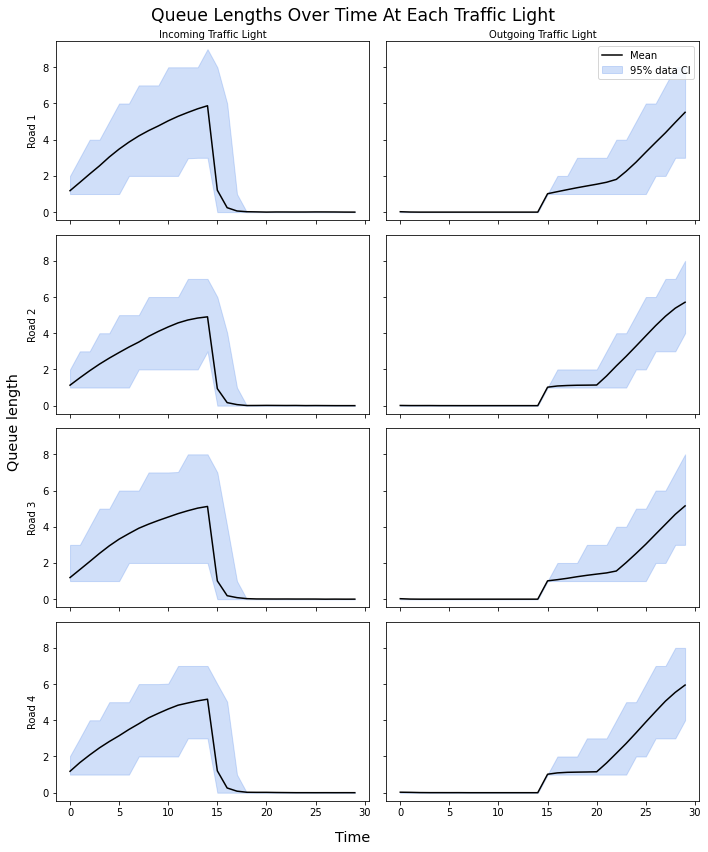

In [ ]:
plot_avg_queue_length()

In [ ]:
def plot_avg_queue_length_hist(steps = 30, trials = 100, road_lengths = [51, 31, 51, 31], car_densities = [0.15, 0.14, 0.14, 0.15], 
                prob_slows = [0.2, 0.2, 0.2, 0.2], max_speeds = [8, 8, 8, 8], turn_probs = [0.36, 0.20, 0.43, 0.19], light_time = 15):
    """
    Plot a histogram of the average queue lengths across all traffic lights in a the traffic simulation,
    including the empirical and theoretical mean queue lengths.

    Parameters
    ----------
    steps : int, optional
        The number of simulation steps to run, by default 30.
    trials : int, optional
        The number of trials to run the simulation, by default 100.
    road_lengths : list of int, optional
        The lengths of the roads in the traffic simulation, by default [51, 31, 51, 31].
    car_densities : list of float, optional
        The densities of cars on each road in the traffic simulation, by default [0.15, 0.14, 0.14, 0.15].
    prob_slows : list of float, optional
        The probability that a car on each road in the traffic simulation will slow down, by default [0.2, 0.2, 0.2, 0.2].
    max_speeds : list of int, optional
        The maximum speeds of cars on each road in the traffic simulation, by default [8, 8, 8, 8].
    turn_probs : list of float, optional
        The probabilities of a car turning at each intersection in the traffic simulation, by default [0.36, 0.20, 0.43, 0.19].
    light_time : int, optional
        The time that each traffic light stays green, by default 15.
    """
    queue_lengths = []

    for _ in range(trials):
        roads = [Road(road_id = i, road_length = road_lengths[i], car_density = car_densities[i], prob_slow = prob_slows[i], 
                    max_speed = max_speeds[i], turn_prob = turn_probs[i]) for i in range(4)]

        # add intersections to road attributes
        for i in range(len(roads)):
            roads[i].define_incoming_road(roads[(i-1) % 4], int(road_lengths[i] * 0.2))
            roads[i].define_outgoing_road(roads[(i+1) % 4], int(road_lengths[i] * 0.8))

        sim = TrafficSimulation(roads = roads, light_time = light_time, surpress_axis = True)
        for i in range(steps):
            sim.update()

        # add queue lengths for one trial
        for road in range(4):
            queue_lengths.append(sim.roads[road].traffic_light_queue_incoming)
            queue_lengths.append(sim.roads[road].traffic_light_queue_outgoing)
    
    # flatten queue list to extract all values for plotting
    queue_lengths = [num for sublist in queue_lengths for num in sublist]
    plt.hist(queue_lengths, bins = range(10), rwidth = 0.9, label = 'Data', color = 'cornflowerblue')
    plt.axvline(np.mean(queue_lengths), label = 'Empirical mean', color = 'cornflowerblue')
    plt.axvline(3.43, label = 'Theoretical mean', color = 'orange')
    plt.xlabel('Queue length')
    plt.ylabel('Frequency')
    plt.title('Average Queue Lengths Across All Traffic Lights')
    plt.legend()
    plt.show()

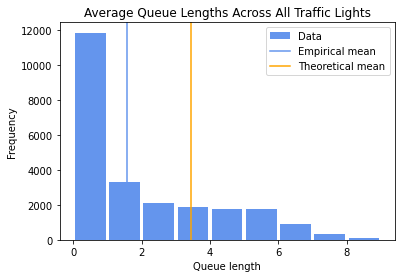

In [ ]:
plot_avg_queue_length_hist()

In [ ]:
import scipy.stats as sts

def plot_avg_flow_speed(steps = 50, trials = 100, road_lengths = [51, 31, 51, 31], car_densities = [0.15, 0.14, 0.14, 0.15], 
                prob_slows = [0.2, 0.2, 0.2, 0.2], turn_probs = [0.36, 0.20, 0.43, 0.19], light_time = 15):
    """
    Plot the average traffic flow across all roads for varying maximum speeds, 
    including the mean, 95% confidence interval of the mean, and 95% confidence
    interval of the data.

    Parameters
    ----------
    steps : int, optional
        Number of simulation steps. The default is 50.
    trials : int, optional
        Number of simulation trials. The default is 100.
    road_lengths : list, optional
        Length of each road. The default is [51, 31, 51, 31].
    car_densities : list, optional
        Density of cars on each road. The default is [0.15, 0.14, 0.14, 0.15].
    prob_slows : list, optional
        Probability of a car slowing down on each road. The default is [0.2, 0.2, 0.2, 0.2].
    turn_probs : list, optional
        Probability of a car turning left or right at each intersection. The default is [0.36, 0.20, 0.43, 0.19].
    light_time : int, optional
        Duration of the green light at each intersection. The default is 15.
    """
    avg_flows = []
    flow_upper = []
    flow_lower = []
    flow_mean_upper = []
    flow_mean_lower = []
    max_speeds = range(16)

    for max_speed in max_speeds:
        flows_temp = []

        for _ in range(trials):
            roads = [Road(road_id = i, road_length = road_lengths[i], car_density = car_densities[i], prob_slow = prob_slows[i], 
                        max_speed = max_speed, turn_prob = turn_probs[i]) for i in range(4)]

            # add intersections to road attributes
            for i in range(len(roads)):
                roads[i].define_incoming_road(roads[(i-1) % 4], int(road_lengths[i] * 0.2))
                roads[i].define_outgoing_road(roads[(i+1) % 4], int(road_lengths[i] * 0.8))

            sim = TrafficSimulation(roads = roads, light_time = light_time, surpress_axis = True)

            for i in range(steps):
                sim.update()

            flows_temp.append(sim.average_traffic_flow)
        
        # compute stats: mean, mean confidence interval, data confidence interval
        avg_flows.append(np.mean(flows_temp))
        flow_upper.append(np.quantile(flows_temp, 0.975))
        flow_lower.append(np.quantile(flows_temp, 0.025))
        flow_mean_upper.append(np.mean(flows_temp) + 1.96 * sts.sem(flows_temp, axis = None))
        flow_mean_lower.append(np.mean(flows_temp) - 1.96 * sts.sem(flows_temp, axis = None))

    # plot mean as dashed line to distinguish from 95% mean CI
    plt.plot(max_speeds, avg_flows, label = 'Mean', color = 'black', linestyle = ':')
    plt.fill_between(max_speeds, flow_lower, flow_upper, label = '95% data CI', alpha = 0.3, color = 'cornflowerblue')
    plt.fill_between(max_speeds, flow_mean_lower, flow_mean_upper, label = '95% mean CI', alpha = 0.5, color = 'cornflowerblue')
    plt.legend()
    plt.xlabel('Maximum speed')
    plt.ylabel('Average flow')
    plt.title('Average Flow for All Roads Across Varying Maximum Speeds')
    plt.show()

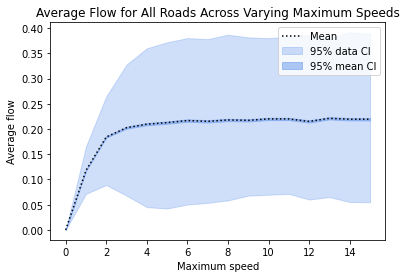

In [ ]:
plot_avg_flow_speed()

In [ ]:
def plot_avg_flow_light_time(steps = 50, trials = 100,  road_lengths = [51, 31, 51, 31], car_densities = [0.15, 0.14, 0.14, 0.15], 
                prob_slows = [0.2, 0.2, 0.2, 0.2], max_speeds = [8, 8, 8, 8], turn_probs = [0.36, 0.20, 0.43, 0.19]):
    """
    Plot the average traffic flow across all roads for varying traffic light intervals, 
    including the mean, 95% confidence interval of the mean, and 95% confidence
    interval of the data.

    Parameters
    ----------
    steps : int, optional
        Number of simulation steps. The default is 50.
    trials : int, optional
        Number of simulation trials. The default is 100.
    road_lengths : list, optional
        Length of each road. The default is [51, 31, 51, 31].
    car_densities : list, optional
        Density of cars on each road. The default is [0.15, 0.14, 0.14, 0.15].
    prob_slows : list, optional
        Probability of a car slowing down on each road. The default is [0.2, 0.2, 0.2, 0.2].
    max_speeds : list of int, optional
        The maximum speeds of cars on each road in the traffic simulation, by default [8, 8, 8, 8].
    turn_probs : list, optional
        Probability of a car turning left or right at each intersection. The default is [0.36, 0.20, 0.43, 0.19].
    """
    avg_flows = []
    flow_upper = []
    flow_lower = []
    flow_mean_upper = []
    flow_mean_lower = []
    light_times = range(5, 31, 2)

    for light_time in light_times:
        flows_temp = []

        for _ in range(trials):
            roads = [Road(road_id = i, road_length = road_lengths[i], car_density = car_densities[i], prob_slow = prob_slows[i], 
                        max_speed = max_speeds[i], turn_prob = turn_probs[i]) for i in range(4)]

            # add intersections to road attributes
            for i in range(len(roads)):
                roads[i].define_incoming_road(roads[(i-1) % 4], int(road_lengths[i] * 0.2))
                roads[i].define_outgoing_road(roads[(i+1) % 4], int(road_lengths[i] * 0.8))

            sim = TrafficSimulation(roads = roads, light_time = light_time, surpress_axis = True)

            for i in range(steps):
                sim.update()

            flows_temp.append(sim.average_traffic_flow)
            
        # compute stats: mean, mean confidence interval, data confidence interval
        avg_flows.append(np.mean(flows_temp))
        flow_upper.append(np.quantile(flows_temp, 0.975))
        flow_lower.append(np.quantile(flows_temp, 0.025))
        flow_mean_upper.append(np.mean(flows_temp) + 1.96 * sts.sem(flows_temp, axis = None))
        flow_mean_lower.append(np.mean(flows_temp) - 1.96 * sts.sem(flows_temp, axis = None))

    # plot mean as dashed line to distinguish from 95% mean CI
    plt.plot(light_times, avg_flows, label = 'Mean', color = 'black', linestyle = ':')
    plt.fill_between(light_times, flow_lower, flow_upper, label = '95% data CI', alpha = 0.3, color = 'cornflowerblue')
    plt.fill_between(light_times, flow_mean_lower, flow_mean_upper, label = '95% mean CI', alpha = 0.5, color = 'cornflowerblue')
    plt.legend()
    plt.xlabel('Light interval')
    plt.ylabel('Average flow')
    plt.title('Average Flow for All Roads Across Varying Traffic Light Intervals')
    plt.show()

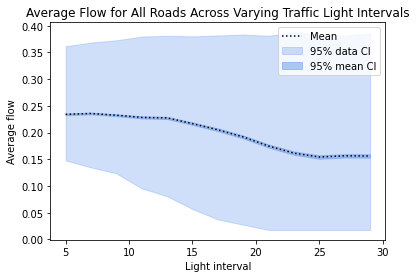

In [ ]:
plot_avg_flow_light_time()

In [ ]:
def plot_speeds_against_light_times(steps = 50, trials = 100, road_lengths = [51, 31, 51, 31], car_densities = [0.15, 0.14, 0.14, 0.15], 
                prob_slows = [0.2, 0.2, 0.2, 0.2], turn_probs = [0.36, 0.20, 0.43, 0.19]):
    """
    Plot a heatmap of the average traffic flow across all roads for varying traffic 
    light intervals and max speeds, including the mean and 95% confidence interval of the data.

    Parameters
    ----------
    steps : int, optional
        Number of simulation steps. The default is 50.
    trials : int, optional
        Number of simulation trials. The default is 100.
    road_lengths : list, optional
        Length of each road. The default is [51, 31, 51, 31].
    car_densities : list, optional
        Density of cars on each road. The default is [0.15, 0.14, 0.14, 0.15].
    prob_slows : list, optional
        Probability of a car slowing down on each road. The default is [0.2, 0.2, 0.2, 0.2].
    max_speeds : list of int, optional
        The maximum speeds of cars on each road in the traffic simulation, by default [8, 8, 8, 8].
    turn_probs : list, optional
        Probability of a car turning left or right at each intersection. The default is [0.36, 0.20, 0.43, 0.19].
    """

    # plausible ranges of speeds and light times to test
    max_speeds = range(2, 15, 2)
    light_times = range(5, 36, 5)
    avg_flow, upper_flow, lower_flow = [], [], []
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex = True, sharey = True)

    # try all pairs of max speeds and light times
    for x in range(len(max_speeds)):
        avg_flow_temp, upper_flow_temp, lower_flow_temp = [], [], []
        for y in range(len(light_times)):
            avg_flow_per_trial = []

            for _ in range(trials):
                roads = [Road(road_id = i, road_length = road_lengths[i], car_density = car_densities[i], prob_slow = prob_slows[i], 
                            max_speed = max_speeds[x], turn_prob = turn_probs[i]) for i in range(4)]

                # add intersections to road attributes
                for i in range(len(roads)):
                    roads[i].define_incoming_road(roads[(i-1) % 4], int(road_lengths[i] * 0.2))
                    roads[i].define_outgoing_road(roads[(i+1) % 4], int(road_lengths[i] * 0.8))

                sim = TrafficSimulation(roads = roads, light_time = light_times[y], surpress_axis = True)
                for i in range(steps):
                    sim.update()

                avg_flow_per_trial.append(sim.average_traffic_flow)

            # calculating mean and 95% confidence interval of data
            avg_flow_temp.append(np.mean(avg_flow_per_trial))
            upper_flow_temp.append(np.quantile(avg_flow_per_trial, 0.975))
            lower_flow_temp.append(np.quantile(avg_flow_per_trial, 0.025))

        # creating a nested list for plotting
        avg_flow.append(avg_flow_temp)
        upper_flow.append(upper_flow_temp)
        lower_flow.append(lower_flow_temp)

    # specify cmap, vmin and vmax so colourbar is the same for all three plots
    ax[0].imshow(lower_flow, origin='lower', vmin = 0, vmax = 0.4, cmap = 'viridis')
    ax[0].set_title('2.5 Percentile')
    ax[1].imshow(avg_flow, origin='lower', vmin = 0, vmax = 0.4, cmap = 'viridis')
    ax[1].set_title('Mean')
    im = ax[2].imshow(upper_flow, origin='lower', vmin = 0, vmax = 0.4, cmap = 'viridis')
    ax[2].set_title('97.5 Percentile')
    fig.supxlabel('Light interval', y = 0.22, fontsize = 'x-large')
    plt.xticks(ticks = range(len(light_times)), labels = light_times)
    fig.supylabel('Max speeds', x = 0.092, fontsize = 'x-large')
    plt.yticks(ticks = range(len(max_speeds)), labels = max_speeds)

    # add colourbar on right
    cbar_ax = fig.add_axes([0.815, 0.3, 0.03, 0.4])
    fig.subplots_adjust(right=0.8, wspace = 0.06)
    fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Average Flow Rates for Varying Maximum Speeds and Light Intervals', y = 0.78, fontsize = 'x-large')
    plt.show()

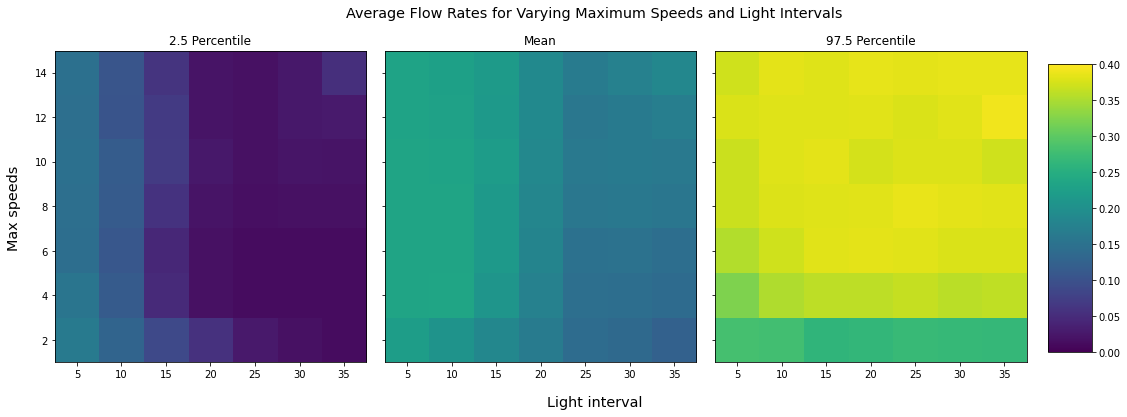

In [ ]:
plot_speeds_against_light_times()